In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('./card_transdata.csv')

In [7]:
s1 = df.head(10)
s2 = df[df["fraud"] == 1].head(10)

m = pd.concat([s1, s2], ignore_index=True)
m.to_csv('./card_transdata_sample.csv', index=False)

In [10]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [12]:
# Check for null values
missing_values = df.isnull().sum()
missing_values

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [15]:
# Shuffle the DataFrame rows
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the features and target variable
X = df_shuffled.drop('fraud', axis=1).values
y = df_shuffled['fraud'].values

# Determine the size of the dataset
dataset_size = len(df_shuffled)

# Calculate the number of training samples (70% of the dataset)
train_size = int(0.7 * dataset_size)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Let's check the shapes of the resulting arrays to confirm our split
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((700000, 7), (300000, 7), (700000,), (300000,))

In [16]:
# Adjusted normalization function to handle zero variance in features
def normalize_features(X_train, X_test):
    """
    Normalize the features in the training and testing set, skipping features with zero variance.
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # Avoid division by zero for features with zero variance
    std[std == 0] = 1
    
    X_train_normalized = (X_train - mean) / std
    X_test_normalized = (X_test - mean) / std
    
    return X_train_normalized, X_test_normalized

# Normalize the training and testing features again
X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)

# Check the mean and standard deviation of the normalized training features to confirm normalization
(X_train_normalized.mean(axis=0), X_train_normalized.std(axis=0))


(array([ 7.92458163e-17,  2.04750502e-17,  2.40061939e-16, -1.22228576e-16,
         6.32789059e-17,  8.81072992e-18, -8.33466629e-17]),
 array([1., 1., 1., 1., 1., 1., 1.]))

In [18]:
# Add a column of ones to the features to account for the intercept
X_train_with_intercept = np.hstack([np.ones((X_train_normalized.shape[0], 1)), X_train_normalized])
X_test_with_intercept = np.hstack([np.ones((X_test_normalized.shape[0], 1)), X_test_normalized])

# Initialize the weights (coefficients) to zeros
weights = np.zeros(X_train_with_intercept.shape[1])

# Display the shapes to verify
(X_train_with_intercept.shape, weights.shape)


((700000, 8), (8,))

In [19]:
def gradient_descent(X, y, weights, learning_rate, iterations):
    """
    Perform gradient descent to learn weights
    """
    n = len(y)
    
    # Store the history of MSE for plotting purposes
    cost_history = []
    
    for _ in range(iterations):
        # Calculate the predictions: X * weights
        predictions = np.dot(X, weights)
        
        # Calculate the error: predictions - y
        error = predictions - y
        
        # Calculate the gradient: (2/n) * X.T * error
        gradient = (2/n) * np.dot(X.T, error)
        
        # Update the weights: weights - learning_rate * gradient
        weights -= learning_rate * gradient
        
        # Calculate the mean squared error (MSE)
        mse = np.mean(error**2)
        cost_history.append(mse)
    
    return weights, cost_history

# Set the number of iterations and the learning rate
iterations = 1000
learning_rate = 0.01

# Perform gradient descent
weights, cost_history = gradient_descent(X_train_with_intercept, y_train, weights, learning_rate, iterations)

# Output the final weights and the last MSE from the cost history
(weights, cost_history[-1])


(array([ 0.08737   ,  0.05424787,  0.02464133,  0.13117388, -0.00823487,
        -0.01748184, -0.02841964,  0.05419847]),
 0.055023923239731355)

In [20]:
def mean_squared_error(y_true, y_pred):
    """
    Calculate the mean squared error between true and predicted values.
    """
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

# Calculate predictions for the test set
y_pred_test = np.dot(X_test_with_intercept, weights)

# Calculate the mean squared error for the test set
mse_test = mean_squared_error(y_test, y_pred_test)

mse_test


0.05531655788978123

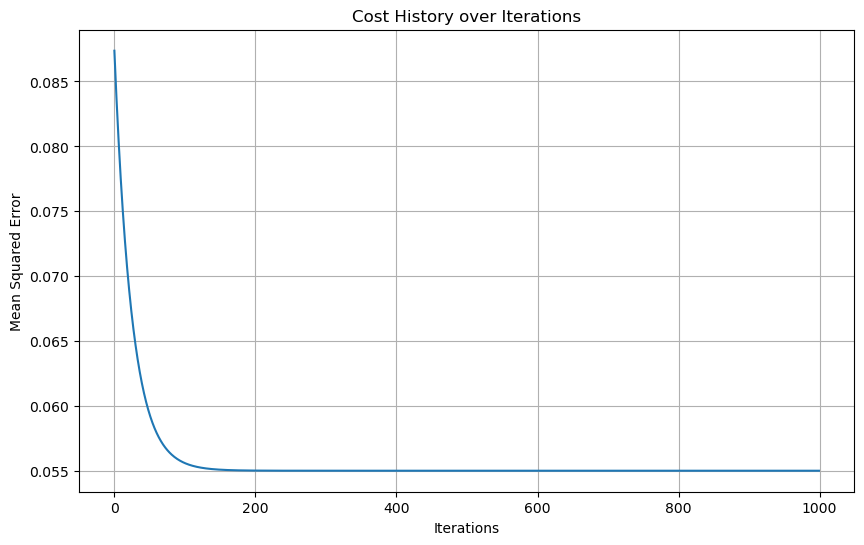

In [24]:
# Plot the cost history over iterations
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Cost History over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


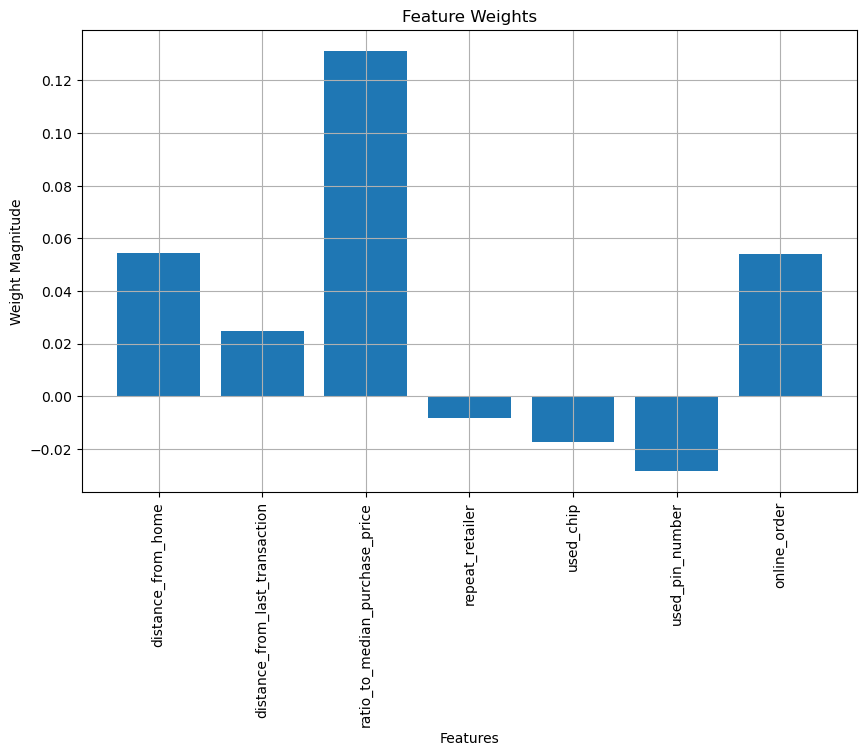

In [25]:
# Create a bar chart for the weights of the model
plt.figure(figsize=(10, 6))

# Since the first weight is the intercept, we exclude it from the plot to focus on the features
features = df.columns.drop('fraud')
indices = np.arange(len(features))
plt.bar(indices, weights[1:])  # Exclude the intercept weight for plotting

plt.title('Feature Weights')
plt.xlabel('Features')
plt.ylabel('Weight Magnitude')
plt.xticks(indices, features, rotation=90)
plt.grid(True)
plt.show()

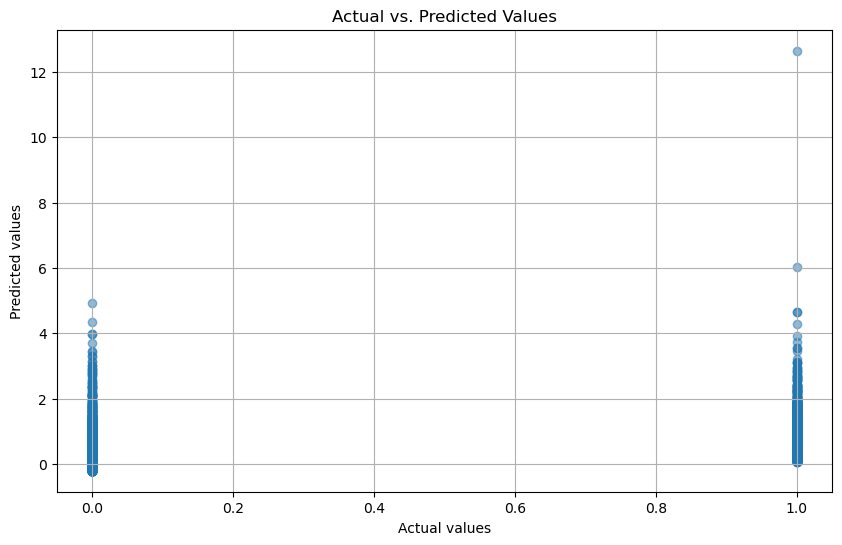

In [26]:
# Scatter plot to compare the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()


## Resumen y Explicación de los Pasos

### 1. Carga de Datos
Utilizamos Pandas para cargar los datos desde un archivo CSV a un DataFrame para inspeccionar y entender la estructura de los datos.

### 2. Preprocesamiento de Datos
Verificamos si había valores faltantes en el conjunto de datos. No había ninguno, lo que simplificó este paso.

### 3. Separación de Datos
Dividimos el conjunto de datos en características independientes (X) y la variable dependiente objetivo (y), que en este caso es si la transacción fue fraudulenta o no.

### 4. Normalización de Características
Normalizamos las características para que contribuyan proporcionalmente al modelo predictivo, asegurándonos de manejar correctamente las características con varianza cero.

### 5. Creación del Modelo de Regresión
Preparamos las matrices de características agregando un término de intercepción y inicializamos los pesos del modelo a cero.

### 6. Entrenamiento del Modelo (Descenso del Gradiente)
Implementamos el algoritmo de descenso del gradiente para minimizar el error cuadrático medio (MSE) y encontrar los mejores pesos para el modelo.

### 7. Evaluación del Modelo
Calculamos el MSE usando el conjunto de pruebas para evaluar el rendimiento del modelo.

### 8. Generación de Gráficos
Creamos gráficos para visualizar la historia de costos durante el entrenamiento, la magnitud de los pesos de las características y la comparación entre los valores reales y los predichos.

## Conclusiones

- El modelo de regresión lineal múltiple se entrenó con éxito utilizando el descenso del gradiente.
- Los gráficos proporcionan una visualización útil del proceso de aprendizaje y la importancia de las características.
- El MSE del conjunto de pruebas fue de aproximadamente 0.055, lo cual indica capacidad predictiva del modelo.

